# Анализ тарифов сотового аператора

В нашем распоряжении данные компании «Мегалайн» оператора сотовой связи. Нам нужно скорректировать рекламный бюджет. 
Есть  500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
- Тариф «Смарт»:
    - Ежемесячная плата: 550 рублей
    - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета:
         - минута разговора: 3 рубля
         - сообщение: 3 рубля
         - 1 Гб интернет-трафика: 200 рублей
- Тариф «Ультра»
    - Ежемесячная плата: 1950 рублей
    - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    - Стоимость услуг сверх тарифного пакета:
         - минута разговора: 1 рубль
         - сообщение: 1 рубль
         - 1 Гб интернет-трафика: 150 рублей

Описание данных

- Таблица users (информация о пользователях):
     - user_id — уникальный идентификатор пользователя
     - first_name — имя пользователя
     - last_name — фамилия пользователя
     - age — возраст пользователя (годы)
     - reg_date — дата подключения тарифа (день, месяц, год)
     - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
     - city — город проживания пользователя
     - tarif — название тарифного плана
- Таблица calls (информация о звонках):
     - id — уникальный номер звонка
     - call_date — дата звонка
     - duration — длительность звонка в минутах
     - user_id — идентификатор пользователя, сделавшего звонок
- Таблица messages (информация о сообщениях):
     - id — уникальный номер сообщения
     - message_date — дата сообщения
     - user_id — идентификатор пользователя, отправившего сообщение
- Таблица internet (информация об интернет-сессиях):
     - id — уникальный номер сессии
     - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
     - session_date — дата интернет-сессии
     - user_id — идентификатор пользователя
     - Таблица tariffs (информация о тарифах):
     - tariff_name — название тарифа
     - rub_monthly_fee — ежемесячная абонентская плата в рублях
     - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
     - messages_included — количество сообщений в месяц, включённых в абонентскую плату
     - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
     - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
     - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
     - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

читаю данные

In [2]:
dt = pd.read_csv('/Users/Дима/tariffs.csv')
dc = pd.read_csv('/Users/Дима/calls.csv')
di = pd.read_csv('/Users/Дима/internet.csv', index_col=0)
dm = pd.read_csv('/Users/Дима/messages.csv')
du = pd.read_csv('/Users/Дима/users.csv')

<b><p style="font-size: 25px;">Подготовка данных.</p></b>

<b> Изучаю и подготавливаю данные</b>

изучаю датафрейм с тарифами

In [3]:
dt.head(2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


в датафрейме 2 строки, все значенияцелочисленные, кроме названий тарифов.

Изучаю датафрейм с звонками

In [5]:
dc.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В датафрейме пропусков нет, всего 202 607 строк

Переводим дату звонка в тип to_datetime и добавлем в датафрейм колонку - месяц

In [7]:
dc['call_date'] = pd.to_datetime(dc['call_date'])
dc['month'] = dc['call_date'].dt.strftime('%B')
display(dc.head(5))

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,July
1,1000_1,2018-08-17,0.00,1000,August
2,1000_2,2018-06-11,2.85,1000,June
3,1000_3,2018-09-21,13.80,1000,September
4,1000_4,2018-12-15,5.18,1000,December


Группируем данные и вычисляем общую длительность и количество звонков в месяц.
Округляем длительность звонков до целых значений

In [8]:
dc['duration'] = np.ceil(dc['duration'])

In [9]:
count_calls = dc.pivot_table(index=['user_id','month'], values='duration', aggfunc=['sum', 'count'])


преобразуем сводную таблицу звонков в датафрейм

In [10]:
count_calls = count_calls.reset_index()
count_calls.columns=['user_id', 'month', 'sum_duration', 'count_duration'] 

In [11]:
count_calls.head(10)

,user_id,month,sum_duration,count_duration
0,1000,August,408.0,52
1,1000,December,333.0,46
2,1000,July,340.0,47
3,1000,June,172.0,43
4,1000,May,159.0,22
5,1000,November,338.0,43
6,1000,October,350.0,57
7,1000,September,466.0,58
8,1001,December,414.0,63
9,1001,November,430.0,59


In [12]:
count_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3174 non-null   int64  
 1   month           3174 non-null   object 
 2   sum_duration    3174 non-null   float64
 3   count_duration  3174 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 99.3+ KB


выводим датафрейм со звонками и проверяем его

Изучаем Датафрейм с сообщениями

In [13]:
dm.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В датафрейме попусков нет, всего 123 036 строк

Переводим дату отправленных сообщений в тип to_datetime и добавлем в датафрейм колонку - месяц

In [15]:
dm['message_date'] = pd.to_datetime(dm['message_date'])
dm['month'] = dm['message_date'].dt.strftime('%B')
display(dm.head(5))

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,June
1,1000_1,2018-10-08,1000,October
2,1000_2,2018-08-04,1000,August
3,1000_3,2018-06-16,1000,June
4,1000_4,2018-12-05,1000,December


Группируем данные по user_id и месяцу и подсчитываем общее количество сообщений за каждый месяц

In [16]:
count_messages = dm.pivot_table(index=['user_id','month'], values='message_date', aggfunc='count')

Преобразовываем сводную таблицу в датафрейм

In [17]:
count_messages = count_messages.reset_index()
columns=['user_id', 'month', 'message_date'] 

Выводим сформированный датафрейм. 

In [18]:
display(count_messages.head(5))
count_messages.info()

,user_id,month,message_date
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       2717 non-null   int64 
 1   month         2717 non-null   object
 2   message_date  2717 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 63.8+ KB


В датафрейме пропусков нет, всего 2717 строк

Изучаем Датафрейм с использованным интернет трафиком

In [19]:
di.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [20]:
di.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


В Датафрейме пропусков нет.

Преобразуем дату интернет сессий в тип to_datetime и добавлем в датафрейм колонку - месяц

In [21]:
di['session_date'] = pd.to_datetime(di['session_date'])
di['month'] = di['session_date'].dt.strftime('%B')
display(di.head(5))

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,November
1,1000_1,1052.81,2018-09-07,1000,September
2,1000_2,1197.26,2018-06-25,1000,June
3,1000_3,550.27,2018-08-22,1000,August
4,1000_4,302.56,2018-09-24,1000,September


Группируем данные по user_id и месяцу и подсчитываем общее количество интернет трафика за каждый месяц

Преобразовываем сгруппированные данные в удобный датафрейм

In [22]:
count_internet_trafic = di.pivot_table(index=['user_id','month'], values='mb_used', aggfunc='sum').round()
count_internet_trafic = count_internet_trafic.reset_index()
columns=['user_id', 'month', 'mb_used'] 
display(count_internet_trafic.head(5))
count_internet_trafic.info()

,user_id,month,mb_used
0,1000,August,14056.0
1,1000,December,9818.0
2,1000,July,14004.0
3,1000,June,23234.0
4,1000,May,2253.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  3203 non-null   int64  
 1   month    3203 non-null   object 
 2   mb_used  3203 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 75.2+ KB


Изучаем датафрейм сданными пользователей

In [23]:
du.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [24]:
du.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В датафрейме есть пропуски в столбце churn_date. Пыстые поля в этом столбце показывает, что обонент еще пользуется услугами оператора на момент выгрузки базы. Поэтому заполнятьпустые поля не имеет принципиального значения.


<b> Объединение датофремов в один </b>

Объеденяю все датафреймы по  столбцу user_id

In [25]:
merge_data = du.merge(count_calls, on='user_id', how='outer')

In [26]:
merge_data = merge_data.merge(count_messages,  on=['user_id', 'month'], how='outer')

In [27]:
merge_data = merge_data.merge(count_internet_trafic, on=['user_id','month'], how='outer')

In [28]:
merge_data.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,count_duration,message_date,mb_used
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,52.0,81.0,14056.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,46.0,70.0,9818.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,47.0,75.0,14004.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,43.0,60.0,23234.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,22.0,22.0,2253.0


переименновываю столбец в датафрейме с данными по тарифу и объединяю с Датафреймом merge_data

In [29]:
dt.rename(columns={'tariff_name' : 'tariff'}, inplace = True)

In [30]:
merge_data = merge_data.merge(dt, on='tariff', how='left')
display(merge_data.head(5))


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,count_duration,message_date,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,52.0,81.0,14056.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,46.0,70.0,9818.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,47.0,75.0,14004.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,43.0,60.0,23234.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,22.0,22.0,2253.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0


In [31]:
#перевожу интернет трафик вклюенный в пакет 
merge_data['gb_per_month_included'] = (merge_data['mb_per_month_included']/1024)
#добовляю новыйстолбец в датафрейм в который перевожу использованный трафик в мб в гб и окруляю
merge_data['mb_used'] =np.ceil( merge_data['mb_used'])
merge_data['gb_used'] = (merge_data['mb_used']/1024)
merge_data['gb_used'] = np.ceil(merge_data['gb_used'])
display(merge_data.head(5))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,...,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,...,14056.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,...,9818.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,10.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,...,14004.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,...,23234.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,23.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,...,2253.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,3.0


In [33]:
merge_data.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,...,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,...,14056.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,...,9818.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,10.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,...,14004.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,...,23234.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,23.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,...,2253.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,3.0
5,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,November,338.0,...,14756.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0
6,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,October,350.0,...,14702.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0
7,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,September,466.0,...,14569.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0
8,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,December,414.0,...,14037.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,14.0
9,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,November,430.0,...,18429.0,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,15.0,18.0


<b><p style="font-size: 25px;"> Анализ данных</p></b>

<b> Произвожу расчеты трат абонентов </b>

Создаю функции дярасчета основных данных сверх лимита по тарифным планам

подсчитываю превышение длительности разговоров сверх лимита

In [34]:
def over_minutes_included (merge_data):
    if merge_data['sum_duration'] > merge_data['minutes_included']:
        return (merge_data['sum_duration'] - merge_data['minutes_included'])*merge_data['rub_per_minute']
    else: 
        return 0
merge_data['pay_over_min_included'] = merge_data.apply(over_minutes_included, axis=1)
merge_data['pay_over_min_included'] = merge_data['pay_over_min_included'].round()

подсчитываю превышение  сообщений сверх лимита

In [35]:
def over_messages_included (merge_data):
    if merge_data['message_date'] > merge_data['messages_included']:
        return (merge_data['message_date'] - merge_data['messages_included'])*merge_data['rub_per_message']
    else: 
        return 0
merge_data['pay_over_messages_included'] = merge_data.apply(over_messages_included, axis=1)       

In [36]:
def over_gb_included (merge_data):
    if merge_data['gb_used'] > merge_data['gb_per_month_included']:
        return (merge_data['gb_used'] - merge_data['gb_per_month_included']) * 150
    else: 
        return 0
merge_data['pay_over_gb_trafic_included'] = merge_data.apply(over_gb_included, axis=1)


In [37]:
display(merge_data.head(15))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,pay_over_min_included,pay_over_messages_included,pay_over_gb_trafic_included
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0,0.0,0.0,0.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,10.0,0.0,0.0,0.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,14.0,0.0,0.0,0.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,23.0,0.0,0.0,0.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,3.0,0.0,0.0,0.0
5,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,November,338.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0
6,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,October,350.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0
7,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,September,466.0,...,3000.0,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0
8,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,December,414.0,...,500.0,550.0,200.0,3.0,3.0,15.0,14.0,0.0,0.0,0.0
9,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,November,430.0,...,500.0,550.0,200.0,3.0,3.0,15.0,18.0,0.0,0.0,450.0


Считаю общие затраты  каждого абонента за месяц и вывожу получившийся датафрейм

In [38]:
merge_data['expenses'] = merge_data['rub_monthly_fee'] + merge_data['pay_over_min_included'] + merge_data['pay_over_messages_included'] + merge_data['pay_over_gb_trafic_included']
display(merge_data.head(15))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,sum_duration,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,pay_over_min_included,pay_over_messages_included,pay_over_gb_trafic_included,expenses
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,August,408.0,...,1950.0,150.0,1.0,1.0,30.0,14.0,0.0,0.0,0.0,1950.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,December,333.0,...,1950.0,150.0,1.0,1.0,30.0,10.0,0.0,0.0,0.0,1950.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,July,340.0,...,1950.0,150.0,1.0,1.0,30.0,14.0,0.0,0.0,0.0,1950.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,June,172.0,...,1950.0,150.0,1.0,1.0,30.0,23.0,0.0,0.0,0.0,1950.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,May,159.0,...,1950.0,150.0,1.0,1.0,30.0,3.0,0.0,0.0,0.0,1950.0
5,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,November,338.0,...,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0,1950.0
6,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,October,350.0,...,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0,1950.0
7,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,September,466.0,...,1950.0,150.0,1.0,1.0,30.0,15.0,0.0,0.0,0.0,1950.0
8,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,December,414.0,...,550.0,200.0,3.0,3.0,15.0,14.0,0.0,0.0,0.0,550.0
9,1001,41.0,NaN,Москва,Иван,Ежов,2018-11-01,smart,November,430.0,...,550.0,200.0,3.0,3.0,15.0,18.0,0.0,0.0,450.0,1000.0


Изучаю полуившийся датафрейм

In [39]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      3222 non-null   int64  
 1   age                          3182 non-null   float64
 2   churn_date                   189 non-null    object 
 3   city                         3182 non-null   object 
 4   first_name                   3182 non-null   object 
 5   last_name                    3182 non-null   object 
 6   reg_date                     3182 non-null   object 
 7   tariff                       3182 non-null   object 
 8   month                        3214 non-null   object 
 9   sum_duration                 3174 non-null   float64
 10  count_duration               3174 non-null   float64
 11  message_date                 2717 non-null   float64
 12  mb_used                      3203 non-null   float64
 13  messages_included 

заполняю все выявленные пропуски

In [40]:
merge_data = merge_data.fillna(0)

In [41]:
#проверяю 
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222 entries, 0 to 3221
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      3222 non-null   int64  
 1   age                          3222 non-null   float64
 2   churn_date                   3222 non-null   object 
 3   city                         3222 non-null   object 
 4   first_name                   3222 non-null   object 
 5   last_name                    3222 non-null   object 
 6   reg_date                     3222 non-null   object 
 7   tariff                       3222 non-null   object 
 8   month                        3222 non-null   object 
 9   sum_duration                 3222 non-null   float64
 10  count_duration               3222 non-null   float64
 11  message_date                 3222 non-null   float64
 12  mb_used                      3222 non-null   float64
 13  messages_included 

Делаю срез по тарифам:

In [42]:
tariff_smart = merge_data[merge_data['tariff'] == 'smart']
tariff_ultra = merge_data[merge_data['tariff'] == 'ultra']

In [43]:
tariff_stat_mean = merge_data.pivot_table(index = 'tariff', values='sum_duration', aggfunc=['mean','var','std'])
tariff_stat_mean = tariff_stat_mean.reset_index()

tariff_stat_mean.columns=['tariff','mean_sum_duration', 'var_sum_duration', 'std_sum_duration'] 
tariff_stat_mean = tariff_stat_mean.round()
tariff_stat_mean

,tariff,mean_sum_duration,var_sum_duration,std_sum_duration
0,0,0.0,0.0,0.0
1,smart,419.0,35970.0,190.0
2,ultra,542.0,95468.0,309.0


 произвел расчет: среднее, дисперсия, и стандартное отклонение по тарифам по длительности звонков

In [44]:
tariff_stat_message = merge_data.pivot_table(index = 'tariff', values='message_date', aggfunc=['mean','var','std'])
tariff_stat_message =tariff_stat_message.reset_index()
tariff_stat_message.columns=['tariff','mean_smessage_date', 'var_message_date', 'std_message_date'] 
tariff_stat_message = tariff_stat_message.round()
tariff_stat_message

,tariff,mean_smessage_date,var_message_date,std_message_date
0,0,54.0,4157.0,64.0
1,smart,33.0,799.0,28.0
2,ultra,49.0,2200.0,47.0


 произвел расчет: среднее, дисперсия, и стандартное отклонение по тарифам по количеству сообщений

In [45]:
tariff_stat_internet = merge_data.pivot_table(index = 'tariff', values='gb_used', aggfunc=['mean','var','std'])
tariff_stat_internet = tariff_stat_internet.reset_index()
tariff_stat_internet.columns=['tariff','mean_gb_used', 'var_gb_used', 'std_gb_used'] 
tariff_stat_internet = tariff_stat_internet.round()
tariff_stat_internet

,tariff,mean_gb_used,var_gb_used,std_gb_used
0,0,19.0,70.0,8.0
1,smart,16.0,33.0,6.0
2,ultra,19.0,100.0,10.0


Произвел расчет: среднее, дисперсия, и стандартное отклонение по тарифам по интернет трафику

In [46]:
tariff_stat_expenses = merge_data.pivot_table(index = 'tariff', values='expenses', aggfunc=['mean','var','std'])
tariff_stat_expenses = tariff_stat_expenses.reset_index()
tariff_stat_expenses.columns=['tariff','mean_expenses', 'var_expenses', 'std_expenses'] 
tariff_stat_expenses = tariff_stat_expenses.round()
tariff_stat_expenses

,tariff,mean_expenses,var_expenses,std_expenses
0,0,0.0,0.0,0.0
1,smart,1141.0,418303.0,647.0
2,ultra,2070.0,143150.0,378.0


Произвел расчет: среднее, дисперсия, и стандартное отклонение  трат по тарифам 

<b> Вывожу гистограммы для сравнения парных величин </b>

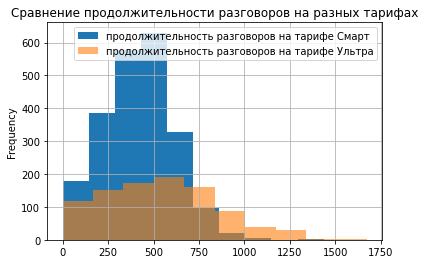

In [47]:
ax = (tariff_smart['sum_duration']
    .plot(
        kind='hist',
        y='col1',
        linewidth=2,
        legend=True,
        label='продолжительность разговоров на тарифе Смарт',
    )
)
(
    tariff_ultra['sum_duration']
    .plot(
        kind='hist',
        y='col2',
        alpha=0.6,
        legend=True,
        
        label='продолжительность разговоров на тарифе Ультра',
        title='Сравнение продолжительности разговоров на разных тарифах',
        
        grid=True,
          )
);
plt.show()

На гистограмме видно, что абоненты на тарифе Смарт чаще превышают лимит включенных в тариф минут.

А абоненты тарифа Ультра не используют полностью лимит

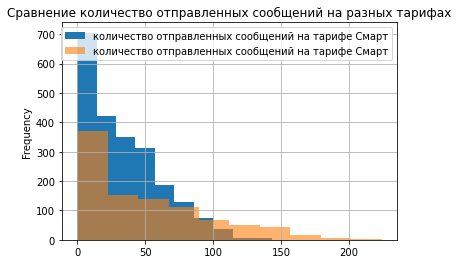

In [48]:
ax = (tariff_smart['message_date']
    .plot(
        kind='hist',
        y='col1',
        linewidth=2,
        legend=True,
        label='количество отправленных сообщений на тарифе Смарт',
    )
)

(
    tariff_ultra['message_date']
    .plot(
        kind='hist',
        y='col2',
        #ax=ax,
        alpha=0.6,
        legend=True,
       
        label='количество отправленных сообщений на тарифе Смарт',
        title='Сравнение количество отправленных сообщений на разных тарифах',
        grid=True,
    )
);
plt.show()

Нагистограмме видно, что часть абонентов практиески не пользубтся смс. 

При этом на тарифе Смарт чаще превышают лимит сообщений чем на тарифе Ультра 

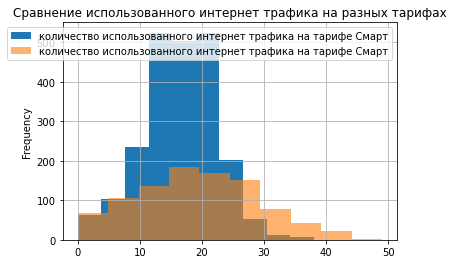

In [49]:
ax = (tariff_smart['gb_used']
    .plot(
        kind='hist',
        y='col1',
        linewidth=2,
        legend=True,
        label='количество использованного интернет трафика на тарифе Смарт',
    )
)

(
    tariff_ultra['gb_used']
    .plot(
        kind='hist',
        y='col2',
        #ax=ax,
        alpha=0.6,
        legend=True,
       
        label='количество использованного интернет трафика на тарифе Смарт',
        title='Сравнение использованного интернет трафика на разных тарифах',
        grid=True,
    )
);
plt.show()

На диаграмме видно в основном абоненты используют от 8 до 25 гб травика,причем большинство абонентов на тарифе Смарт используют от 11 до 22 гб трафика.

Это говорит о том что они чаще превышают лимит трафика, чем абоненты на тарифе Ультра.

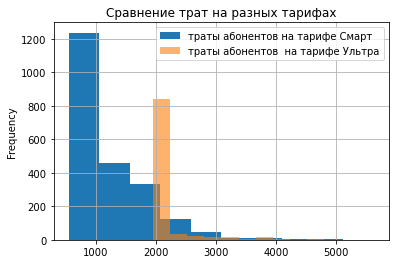

In [50]:
ax = (tariff_smart['expenses']
    .plot(
        kind='hist',
        y='col1',
        linewidth=2,
        legend=True,
        label='траты абонентов на тарифе Смарт',
    )
)

(
    tariff_ultra['expenses']
    .plot(
        kind='hist',
        y='col2',
        #ax=ax,
        alpha=0.6,
        legend=True,
       
        label='траты абонентов  на тарифе Ультра',
        title='Сравнение трат на разных тарифах',
        grid=True,
    )
);
plt.show()

На гистограмме видно что в большинство  обонентов на тарифе Смарт тратят от 550 до 1050р в месяц,а траты абонентов  на тарифе Ультра составляют от 1950 до 2200р

<b> Проверка гипотез </b>

Нулевая гипотеза сформулирована следующим образом: средняя выручка с пользователей тарифов «Ультра» и «Смарт» не различаются.
    
Формулируем альтернативную гипотизу: средняя выручка с пользователей тарифов «Ультра» и «Смарт»  различается. 

In [51]:
tariff_smart = merge_data[merge_data['tariff'] == 'smart']
tariff_smart_expenses = tariff_smart['expenses']
tariff_ultra = merge_data[merge_data['tariff'] == 'ultra']
tariff_ultra_expenses = tariff_ultra['expenses']

In [52]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    tariff_smart_expenses, 
    tariff_ultra_expenses)

print('p-значение: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.00
Отвергаем нулевую гипотезу


Исходя из полуенного значения p-valuе, что вероятность получить такое или большее значение равно 0%.

Значит можно вывод о том что средняя выручка с пользователей тарифов «Ультра» и «Смарт»  различается

Формулируем нулевую гипотезу: средняя выручка с пользователей из Москвы не отличается от выручки с пользователей из других регионов.
    
Альтернативная гипотеза: средняя выручка с пользователей из Москвы  отличается от выручки с пользователей из других регионов.
       

In [53]:
users_moscow_city = merge_data.query('city == "Москва"')
users_moscow_city_expenses = users_moscow_city['expenses']
other_users = merge_data.query('city != "Москва"')
other_users_expenses = other_users['expenses']

In [54]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    users_moscow_city_expenses, 
    other_users_expenses)

print('p-значение: {:.2f}' .format(results.pvalue))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.04
Отвергаем нулевую гипотезу


Исходя из полуенного значения p-valuе, что вероятность получить такое или большее значение равно 10% при значении alpha = 0.05.

Делаем вывод,что мы  можем отвергнуть нулевую гипотезу, а значит делаем предположение, что средняя выручка с пользователей из Москвы отличается от выручки с пользователей из других регионов.

# Вывод

При анализе Тарифов сотового аператора были изучены  данные сотового обератора

Изучены данные таблиц, данные были приведены к нужным типам (дата и время). Были объеденены таблицы в один датафрейм.

 В Датафрейм были дабавлены данные превышения лимитов тарифа по длительности звонков, сообщений и  интернет трафика. Также для расчета итоговых затрат абонентов мегабайты были переведены в гигобайты.
 
 Посчитаны итоговые траты абонентов в месяц по тарифам.
 
 Проверили данные полученного датафрема на пропуски. Выявили пропуски в столбцах: churn_date, message_date, gb_used. Пропуски в столбце churn_date - это абоненты которые пользуются услугами компании на момент выгрузки, значит они нам не мешают для дальнейшего анализа. Пропуски в столбцах: message_date, gb_used возможны из-за того что абоненты могли не пользоваться данными услугами.
 
заполняем пропуски 0 и перепроверяем.

Делаем срезы по тарифам для построения гистограмм в дальнейшем

Рассчитываю по тарифам среднее, дисперсию, и стандартное отклонение:
  - по израсходованным минутам;
  - по количеству сообщений;
  - по количеству использованного трафика;
  - по месячным тратам абонентов.
  
Построил гистограммы на которых вывел ставнение двух тарифов:
  - по израсходованным минутам;
  - по количеству сообщений;
  - по количеству использованного трафика;
  - по месячным тратам абонентов.
  
Пришел к следующим выводам:
  - абоненты на тарифе Смарт чаще превышают лимит включенных в тариф минут;
  - часть абонентов не посылают сообщения. Обоненты тарифа Смарт чаще превышают лимит свключенных в тариф сообщений;
  - абоненты на тарифе Смарт чаще превышают лимит включенных в тариф гигабат трафика;
  - абоненты на тарифе Смарт тратят дополнительно больше денег, чем на тарифе Ультра.
  
Исходя из проведенного анализа видно что абоненты тарифа Смарт тратят больше денег на связь. Соответственно можно сделать предположение, что тариф Смарт приносит больше денег.


На этапе проверки гипотез мы сформулировали нулевые и альтернативные гипотизы.

При проверке гипотиз использовал  значение alpha =0.05 - критический уровень статистической значимости, тк выборка позволяет использовать менее строгий уровень значимости. 

Певая нулевая гипотеза звучала: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Алетернативная: средняя выручка пользователей тарифов «Ультра» и «Смарт»  не различаются.

После расчета р-значения, которое равно - 0, была отвергнута нулевая гипотеза. Значит можно вывод о том что средняя выручка с пользователей тарифов «Ультра» и «Смарт» не различается.

Вторая нулевая гипотеза: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Альтернативная: средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов.

После расчета р-значения, которое равно - 0.10, была отвергнута ннулевая гипотеза. Делаем вывод,что мы не можем отвергнуть нулевую гипотезу, а значит делаем предположение, что средняя выручка с пользователей из Москвы отличается от выручки с пользователей из других регионов.


  
  
  